<a href="https://colab.research.google.com/github/tanwalai/study/blob/main/Assignment02_ml_6610422010.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install package

In [ ]:
!pip install requests
!pip install lxml
!pip install yfinance

In [ ]:
# Technical Indicators
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xvzf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install TA-Lib

--2024-02-24 11:37:46--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2024-02-24 11:37:46--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://newcontinuum.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2024-02-24 11:37:46--  http://newcontinuum.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving newco

## Import packages

In [ ]:
# Data Manipulation
import numpy as np
import pandas as pd
import yfinance as yf

# Technical Indicators
import talib as ta

# Plotting graphs
import matplotlib.pyplot as plt

# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score

# Train Test Split
from sklearn.model_selection import train_test_split

## Part A : develop logistic regression model to predict stock
- In this project I used Nvidia stock data.

In [447]:
# Step1 : Define interval, start and end date
interval = '1h'
start = '2023-01-01'
end = '2024-01-31'

In [448]:
# Step2 : Import NVDA stock data
nvd = yf.Ticker('NVDA')

In [449]:
# explore nvd data
nvd_df = nvd.history(interval=interval,start=start,end=end)
print(nvd_df.shape)
print(nvd_df.head())

(1882, 7)
                                 Open        High         Low       Close  \
Datetime                                                                    
2023-01-03 09:30:00-05:00  148.509995  149.960007  143.070007  143.520004   
2023-01-03 10:30:00-05:00  143.529999  143.570007  141.030106  141.960007   
2023-01-03 11:30:00-05:00  141.949997  142.610001  140.960007  141.830093   
2023-01-03 12:30:00-05:00  141.850006  142.860001  141.570007  142.789993   
2023-01-03 13:30:00-05:00  142.800095  142.863098  142.029999  142.271698   

                             Volume  Dividends  Stock Splits  
Datetime                                                      
2023-01-03 09:30:00-05:00  11605646        0.0           0.0  
2023-01-03 10:30:00-05:00   7234854        0.0           0.0  
2023-01-03 11:30:00-05:00   4647010        0.0           0.0  
2023-01-03 12:30:00-05:00   3367135        0.0           0.0  
2023-01-03 13:30:00-05:00   3274138        0.0           0.0  


In [450]:
# Step4 : Define Predictor/Independent Variables
# Create feature for the model
nvd_df['S_14'] = nvd_df['Close'].rolling(window=14).mean()
nvd_df['Corr'] = nvd_df['Close'].rolling(window=10).corr(nvd_df['S_14'])
nvd_df['RSI'] = ta.RSI(np.array(nvd_df['Close']),timeperiod = 10)
nvd_df['Open-Close'] = nvd_df['Open'] - nvd_df['Close'].shift(1)
nvd_df['Open-Open'] = nvd_df['Open'] - nvd_df['Open'].shift(1)

In [451]:
# Step5 : define target variable
nvd_df['y'] = np.where(nvd_df['Close'].shift(-1) > nvd_df['Close'],1,-1)

In [452]:
# Step6 : Explore missing data
nvd_df.isna().sum()
nvd_df = nvd_df.dropna()
nvd_df.shape

(1860, 13)

In [453]:
nvd_df.isna().sum()

Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
S_14            0
Corr            0
RSI             0
Open-Close      0
Open-Open       0
y               0
dtype: int64

In [454]:
data = nvd_df.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12]]
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1860 entries, 2023-01-06 10:30:00-05:00 to 2024-01-30 15:30:00-05:00
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1860 non-null   float64
 1   High          1860 non-null   float64
 2   Low           1860 non-null   float64
 3   Close         1860 non-null   float64
 4   Volume        1860 non-null   int64  
 5   Dividends     1860 non-null   float64
 6   Stock Splits  1860 non-null   float64
 7   S_14          1860 non-null   float64
 8   Corr          1860 non-null   float64
 9   RSI           1860 non-null   float64
 10  y             1860 non-null   int64  
dtypes: float64(9), int64(2)
memory usage: 174.4 KB


In [455]:
# Step6 : split train/test dataset
train,test=train_test_split(data,test_size=0.3,random_state=0,stratify=data['y'])

train_X=train[train.columns[:-1]]
train_Y=train[train.columns[-1]]

test_X=test[test.columns[:-1]]
test_Y=test[test.columns[-1]]

X=data[data.columns[:-1]]
Y=data['y']

In [456]:
print(data.shape)

(1860, 11)


In [457]:
print(train.shape)

(1302, 11)


In [458]:
print(test.shape)

(558, 11)


In [459]:
# Step7 : Develop the logisitc regression model
model = LogisticRegression()

In [460]:
# train the model
model1 = model.fit(train_X,train_Y)

In [461]:
# Step8 : examine the coefficient
pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))

# note : dividends and corr have negative correlation with y ?

,0,1
0,Open,[1.1842339691425099e-12]
1,High,[1.1885520746138008e-12]
2,Low,[1.1833330091207762e-12]
3,Close,[1.1868761185077608e-12]
4,Volume,[1.325865473660653e-08]
5,Dividends,[-4.036980492990684e-18]
6,Stock Splits,[0.0]
7,S_14,[1.1950974125622142e-12]
8,Corr,[-2.683890993378772e-16]
9,RSI,[2.835081633955605e-13]


In [462]:
# Step9 : calculate class probabilities
probability = model1.predict_proba(test_X)
print(probability)

[[0.48189636 0.51810364]
 [0.46417068 0.53582932]
 [0.48424076 0.51575924]
 ...
 [0.45915203 0.54084797]
 [0.48526557 0.51473443]
 [0.46427177 0.53572823]]


In [463]:
# Step10 : predict class labels
predicted = model1.predict(test_X)
print(predicted)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [464]:
test['predict'] = predicted
test.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,S_14,Corr,RSI,y,predict
Datetime,,,,,,,,,,,,
2023-07-20 11:30:00-04:00,461.457703,464.500000,459.880005,460.000000,5464071,0.0,0.0,469.810575,-0.593074,41.541284,1,1
2023-08-15 10:30:00-04:00,439.160004,445.829987,437.500000,445.479401,10827897,0.0,0.0,425.215506,0.757920,77.160584,1,1
2023-06-06 10:30:00-04:00,388.890015,390.899994,387.690002,388.010010,4755977,0.0,0.0,391.673471,0.597832,41.800159,-1,1
2023-03-14 13:30:00-04:00,240.195007,240.609406,237.110001,238.789993,4816960,0.0,0.0,233.611477,0.545665,59.475460,-1,1
2023-10-18 15:30:00-04:00,420.234985,422.609985,418.250000,421.970001,5272873,0.0,0.0,431.903421,0.854463,25.314110,1,1


In [465]:
buy_signal_dates = test[test['predict']==1]
print("\nDate(s) with Buy Signal(s):")
print(buy_signal_dates.index)


Date(s) with Buy Signal(s):
DatetimeIndex(['2023-07-20 11:30:00-04:00', '2023-08-15 10:30:00-04:00',
               '2023-06-06 10:30:00-04:00', '2023-03-14 13:30:00-04:00',
               '2023-10-18 15:30:00-04:00', '2023-08-23 13:30:00-04:00',
               '2023-08-29 09:30:00-04:00', '2023-02-09 12:30:00-05:00',
               '2023-10-10 14:30:00-04:00', '2023-04-24 11:30:00-04:00',
               ...
               '2023-10-17 10:30:00-04:00', '2023-04-05 09:30:00-04:00',
               '2023-04-12 13:30:00-04:00', '2023-04-17 10:30:00-04:00',
               '2023-03-24 09:30:00-04:00', '2023-05-18 11:30:00-04:00',
               '2023-06-12 14:30:00-04:00', '2023-11-27 09:30:00-05:00',
               '2023-03-28 11:30:00-04:00', '2023-10-06 09:30:00-04:00'],
              dtype='datetime64[ns, America/New_York]', name='Datetime', length=558, freq=None)


In [466]:
# Step11 : evaluate the model
# method1 : confusion matrix
print(metrics.confusion_matrix(test_Y,predicted))

[[  0 260]
 [  0 298]]


In [467]:
# method2 : classification report
print(metrics.classification_report(test_Y, predicted))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       260
           1       0.53      1.00      0.70       298

    accuracy                           0.53       558
   macro avg       0.27      0.50      0.35       558
weighted avg       0.29      0.53      0.37       558



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [468]:
# Step12 : compare prediction with the actual y
nvd_df['Predicted_Signal'] = model.predict(X)

# Actual
nvd_df['NVD_returns'] = np.log(nvd_df['Close']/nvd_df['Close'].shift(1))
Cumulative_NVD_returns = np.cumsum(nvd_df['NVD_returns'])

# Model1 prediction
nvd_df['Strategy_returns'] = nvd_df['NVD_returns']* nvd_df['Predicted_Signal'].shift(1)
Cumulative_Strategy_returns = np.cumsum(nvd_df['Strategy_returns'])

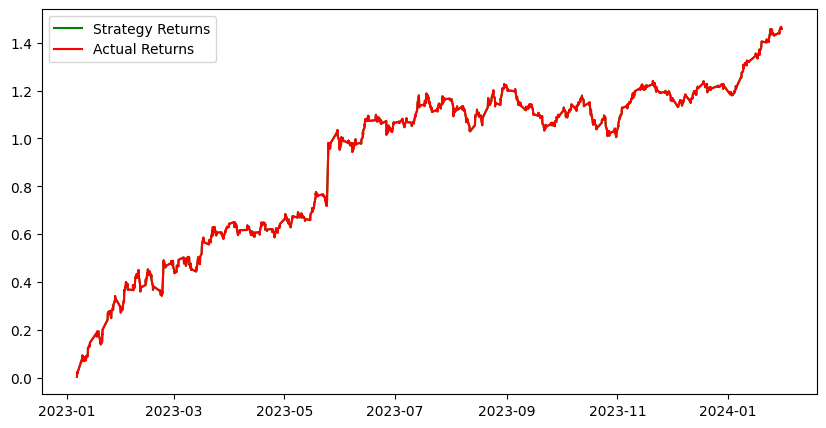

In [469]:
plt.figure(figsize=(10,5))
plt.plot(Cumulative_Strategy_returns, color='g', label = 'Strategy Returns')
plt.plot(Cumulative_NVD_returns, color='r', label = 'Actual Returns')
plt.legend()
plt.show()

# PartB : Add feature to improve the model
- sma50 : 50-period simple moving average of close price
- ema12 : 12-period ema
- ema26 : 26-period ema
- nasdaq index

In [470]:
# Step1 : Add sma50, ema12, ema26 to the data
df = data.copy()
df['sma50'] = df['Close'].rolling(window=50).mean()
df['ema12'] = df['Close'].ewm(span=12, min_periods=12).mean()
df['ema26'] = df['Close'].ewm(span=26, min_periods=26).mean()

In [471]:
# Step2 : Add nasdaq feature
nasdaq = yf.Ticker('^NDX')
nasdaq_df = nasdaq.history(interval=interval,start=start,end=end)

In [472]:
nasdaq_df['nd_s_14'] = nasdaq_df['Close'].rolling(window=14).mean()
nasdaq_df['nd_corr'] = nasdaq_df['Close'].rolling(window=10).corr(nvd_df['S_14'])

In [473]:
nasdaq_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1882 entries, 2023-01-03 09:30:00-05:00 to 2024-01-30 15:30:00-05:00
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1882 non-null   float64
 1   High          1882 non-null   float64
 2   Low           1882 non-null   float64
 3   Close         1882 non-null   float64
 4   Volume        1882 non-null   int64  
 5   Dividends     1882 non-null   float64
 6   Stock Splits  1882 non-null   float64
 7   nd_s_14       1869 non-null   float64
 8   nd_corr       1851 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 211.6 KB


In [474]:
nasdaq_df.rename(columns={'Open': 'nd_open', 'High': 'nd_high','Low':'nd_low','Close':'nd_close','Volume':'nd_volumn','Dividends':'nd_dividends','Stock Splits' : 'nd_stock_splits'}, inplace=True)

In [475]:
nasdaq_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1882 entries, 2023-01-03 09:30:00-05:00 to 2024-01-30 15:30:00-05:00
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   nd_open          1882 non-null   float64
 1   nd_high          1882 non-null   float64
 2   nd_low           1882 non-null   float64
 3   nd_close         1882 non-null   float64
 4   nd_volumn        1882 non-null   int64  
 5   nd_dividends     1882 non-null   float64
 6   nd_stock_splits  1882 non-null   float64
 7   nd_s_14          1869 non-null   float64
 8   nd_corr          1851 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 211.6 KB


In [476]:
model2_data = pd.merge(df,nasdaq_df,left_index=True,right_index=True,how='left')

In [477]:
column_order = list(model2_data.columns)
column_order.remove('y')
column_order.append('y')
model2_data = model2_data[column_order]

In [478]:
model2_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1860 entries, 2023-01-06 10:30:00-05:00 to 2024-01-30 15:30:00-05:00
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open             1860 non-null   float64
 1   High             1860 non-null   float64
 2   Low              1860 non-null   float64
 3   Close            1860 non-null   float64
 4   Volume           1860 non-null   int64  
 5   Dividends        1860 non-null   float64
 6   Stock Splits     1860 non-null   float64
 7   S_14             1860 non-null   float64
 8   Corr             1860 non-null   float64
 9   RSI              1860 non-null   float64
 10  sma50            1811 non-null   float64
 11  ema12            1849 non-null   float64
 12  ema26            1835 non-null   float64
 13  nd_open          1860 non-null   float64
 14  nd_high          1860 non-null   float64
 15  nd_low           1860 non-null   float64
 16  nd_close    

In [479]:
# Step3 : Explore missing data and drop it out
model2_data.isna().sum()

Open                0
High                0
Low                 0
Close               0
Volume              0
Dividends           0
Stock Splits        0
S_14                0
Corr                0
RSI                 0
sma50              49
ema12              11
ema26              25
nd_open             0
nd_high             0
nd_low              0
nd_close            0
nd_volumn           0
nd_dividends        0
nd_stock_splits     0
nd_s_14             0
nd_corr             9
y                   0
dtype: int64

In [480]:
model2_data = model2_data.dropna()
model2_data.shape

(1811, 23)

In [481]:
# Step4 : split train and test dataset
train2,test2 = train_test_split(model2_data,test_size=0.3,random_state=0,stratify=model2_data['y'])

train2_X=train2[train2.columns[:-1]]
train2_Y=train2[train2.columns[-1]]

test2_X=test2[test2.columns[:-1]]
test2_Y=test2[test2.columns[-1]]

X2 = model2_data[model2_data.columns[:-1]]
Y2 = model2_data['y']

In [482]:
print(train2.shape)

(1267, 23)


In [483]:
print(test2.shape)

(544, 23)


In [484]:
# Step5 : Develop the logisitc regression model
model = LogisticRegression()

# train the model
model2 = model.fit(train2_X,train2_Y)

In [485]:
# Step6 : examine the coefficient
pd.DataFrame(zip(X2.columns, np.transpose(model2.coef_)))

,0,1
0,Open,[2.4898562007045357e-13]
1,High,[2.53771281459878e-13]
2,Low,[2.518414982841444e-13]
3,Close,[2.5514230582039436e-13]
4,Volume,[1.0963720580992018e-08]
5,Dividends,[-2.861854818018209e-19]
6,Stock Splits,[0.0]
7,S_14,[2.395150044024851e-13]
8,Corr,[-4.4305430293877113e-16]
9,RSI,[1.2546383292054057e-13]


In [486]:
# Step7 : calculate class probabilities
probability2 = model2.predict_proba(test2_X)
print(probability2)

[[0.47809963 0.52190037]
 [0.47683404 0.52316596]
 [0.48364438 0.51635562]
 ...
 [0.47787727 0.52212273]
 [0.47528265 0.52471735]
 [0.42893097 0.57106903]]


In [487]:
# Step8 : predict class labels
predicted2 = model2.predict(test2_X)
print(predicted2)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [488]:
# Step9 : evaluate the model
# method1 : confusion matrix
print(metrics.confusion_matrix(test2_Y,predicted2))

[[  0 255]
 [  0 289]]


In [489]:
# method2 : classification report
print(metrics.classification_report(test2_Y, predicted2))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       255
           1       0.53      1.00      0.69       289

    accuracy                           0.53       544
   macro avg       0.27      0.50      0.35       544
weighted avg       0.28      0.53      0.37       544



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [493]:
# Step10 : Compare the model
# Model2 prediction
model2_data['Predicted_Signal'] = model2.predict(X2)
model2_data['NVD_returns'] = np.log(model2_data['Close']/model2_data['Close'].shift(1))

model2_data['Strategy_model2_returns'] = model2_data['NVD_returns']*model2_data['Predicted_Signal'].shift(1)
Cumulative_Strategy_model2_returns = np.cumsum(model2_data['Strategy_model2_returns'])

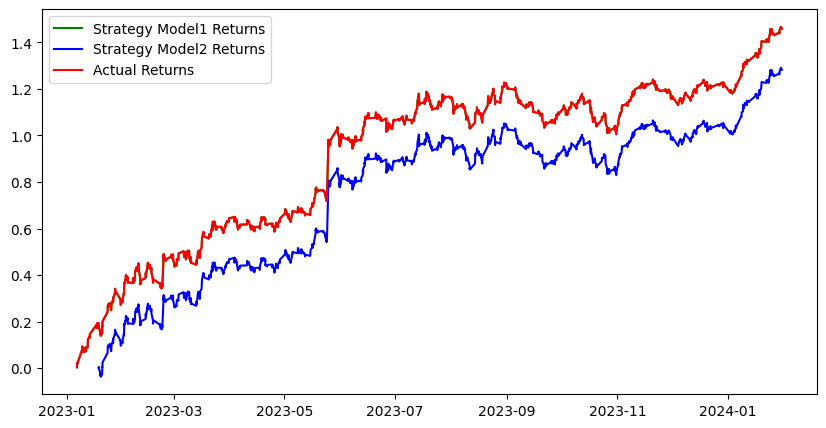

In [494]:
plt.figure(figsize=(10,5))
plt.plot(Cumulative_Strategy_returns, color='g', label = 'Strategy Model1 Returns')
plt.plot(Cumulative_Strategy_model2_returns, color='b', label = 'Strategy Model2 Returns')
plt.plot(Cumulative_NVD_returns, color='r', label = 'Actual Returns')
plt.legend()
plt.show()